In [92]:
import os
import numpy as np
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [93]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"bananapple","key":"75eb3c0872d58bbdaf9df31824376852"}'}

In [94]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection

 96% 414M/431M [00:03<00:00, 130MB/s]
100% 431M/431M [00:03<00:00, 134MB/s]


In [ ]:
#압축풀기
import zipfile

local_zip = '/content/real-and-fake-face-detection.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

# 경로지정

In [95]:
#기본경로

base_dir='/content/real_and_fake_face'

train_fake_dir=os.path.join(base_dir,'training_fake')
train_real_dir=os.path.join(base_dir,'training_real')
print(train_real_dir)

/content/real_and_fake_face/training_real


In [96]:
#리스트에 담아서 데이터 수 확인하기
train_fake_fnames=os.listdir(train_fake_dir)
print(len(train_fake_fnames))

train_real_fnames=os.listdir(train_real_dir)
print(len(train_real_fnames))

960
1081


# 시각화

In [100]:
import cv2
def load_img(img):
    image = cv2.imread(img)
    image = cv2.resize(image, (150, 150))
    return image[...,::-1]

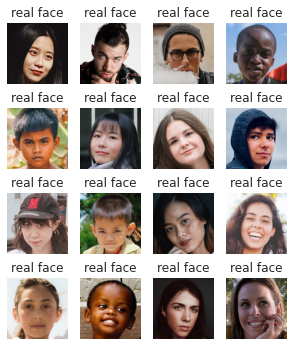

In [101]:
fig = plt.figure(figsize=(5, 6))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(train_real_dir + '/' + train_real_fnames[i]), cmap='gray')
    plt.title("real face")
    plt.axis('off')

plt.show()

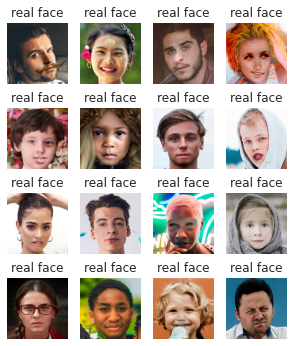

In [102]:
fig = plt.figure(figsize=(5, 6))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(train_fake_dir + '/' + train_fake_fnames[i]), cmap='gray')
    plt.title("real face")
    plt.axis('off')

plt.show()

# 데이터셋/전처리

In [103]:
batch=32
img_height=150
img_width=150

In [111]:
#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=False,
                           rescale=1./255,
                           validation_split=0.2
                          )

train_gen=datagen.flow_from_directory(base_dir,
                                      batch_size=batch,
                                      class_mode='binary',
                                      target_size=(img_height,img_width),
                                      subset="training"
                                      )
val_gen=datagen.flow_from_directory(base_dir,
                                    batch_size=batch,
                                    class_mode='binary',
                                    target_size=(img_height,img_width),
                                    subset="validation"
                                    )

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


# 모델만들기

In [45]:
import tensorflow as tf

tf.__version__

from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.engine.sequential import Sequential
from tensorflow import keras
from keras import regularizers

In [149]:
kernel_s=(3,3)
model=models.Sequential()

model.add(layers.Conv2D(16, kernel_s, activation='relu', input_shape=(img_height,img_width,3), kernel_regularizer=regularizers.l2(0.001), padding='VALID'))
#model.add(layers.Conv2D(16, kernel_s, activation='relu', input_shape=(img_height,img_width,3)))
model.add(layers.MaxPooling2D(2,2))


model.add(layers.Conv2D(32, kernel_s, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, kernel_s, activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, kernel_s, activation='relu'))
model.add(layers.MaxPooling2D(2,2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

In [150]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy')

In [151]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 74, 74, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_102 (Conv2D)         (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 36, 36, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_103 (Conv2D)         (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 17, 17, 64)     

# 학습하기

In [152]:
history=model.fit(train_gen,
                  epochs=10,
                  validation_data=val_gen,
                  )


Epoch 1/10
52/52 [==============================] - 24s 445ms/step - loss: 0.6984 - accuracy: 0.5750 - val_loss: 0.6955 - val_accuracy: 0.5294
Epoch 2/10
52/52 [==============================] - 22s 426ms/step - loss: 0.6460 - accuracy: 0.6289 - val_loss: 0.6970 - val_accuracy: 0.5074
Epoch 3/10
52/52 [==============================] - 22s 417ms/step - loss: 0.6412 - accuracy: 0.6283 - val_loss: 0.7085 - val_accuracy: 0.5294
Epoch 4/10
52/52 [==============================] - 22s 417ms/step - loss: 0.6278 - accuracy: 0.6571 - val_loss: 0.6947 - val_accuracy: 0.5319
Epoch 5/10
52/52 [==============================] - 22s 419ms/step - loss: 0.6162 - accuracy: 0.6638 - val_loss: 0.7136 - val_accuracy: 0.5294
Epoch 6/10
52/52 [==============================] - 22s 417ms/step - loss: 0.5923 - accuracy: 0.6889 - val_loss: 0.6918 - val_accuracy: 0.5564
Epoch 7/10
52/52 [==============================] - 22s 422ms/step - loss: 0.5796 - accuracy: 0.7030 - val_loss: 0.6963 - val_accuracy: 0.5588

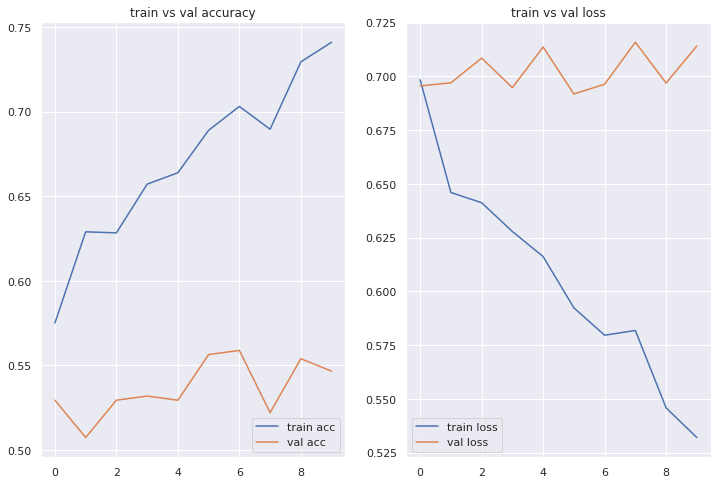

In [153]:
#정확도
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

#오차 확인
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(10)

#accuracy 확인
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='train acc')
plt.plot(epochs_range,val_acc,label='val acc')
plt.legend(loc='lower right')
plt.title('train vs val accuracy')

#오차 확인
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='train loss')
plt.plot(epochs_range,val_loss,label='val loss')
plt.legend()
plt.title('train vs val loss')

plt.show()